# Non-Stationary Flood Frequency Analysis

This vignette demonstrates flood frequency analysis (FFA) under *non-stationarity* using the `ffaframework` package.

The framework supports three forms of non-stationarity, modelled as linear trends in the distribution parameters:

1. A linear trend in the mean (location parameter).
2. A linear trend in the variance (scale parameter).
3. A linear trend in both the mean and variance.

Readers unfamiliar with stationary FFA workflows should first consult the *Stationary FFA* vignette.

## Setup

In [1]:
library(ffaframework)

options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 150) # Set plot size

csv_path <- system.file("extdata", "Application_3.1.csv", package = "ffaframework")
df <- read.csv(csv_path)
df <- subset(df, !is.na(max)) # Remove missing values

head(df)

Loading required package: ggplot2

Loading required package: patchwork



,year,max
,<int>,<dbl>
10,1909,314
11,1910,230
12,1911,264
13,1912,174
14,1913,232
15,1914,214


## The `trend` List

This vignette assumes prior identification of a trend in the mean.

In [2]:
trend <- list(location = TRUE, scale = FALSE)

**Note**: For guidance on trend detection, refer to the *Trend Identification* vignette.



## Distribution Selection

L-moment-based distribution selection remains applicable under non-stationarity, but requires detrending prior to analysis.
This is accomplished using the `ams_decomposition` function, which takes a vector of streamflow observations, the corresponding vector of years, and the `trend` object.
The decomposed vector of streamflow observations is then passed to the selection function.

[1] "GNO"


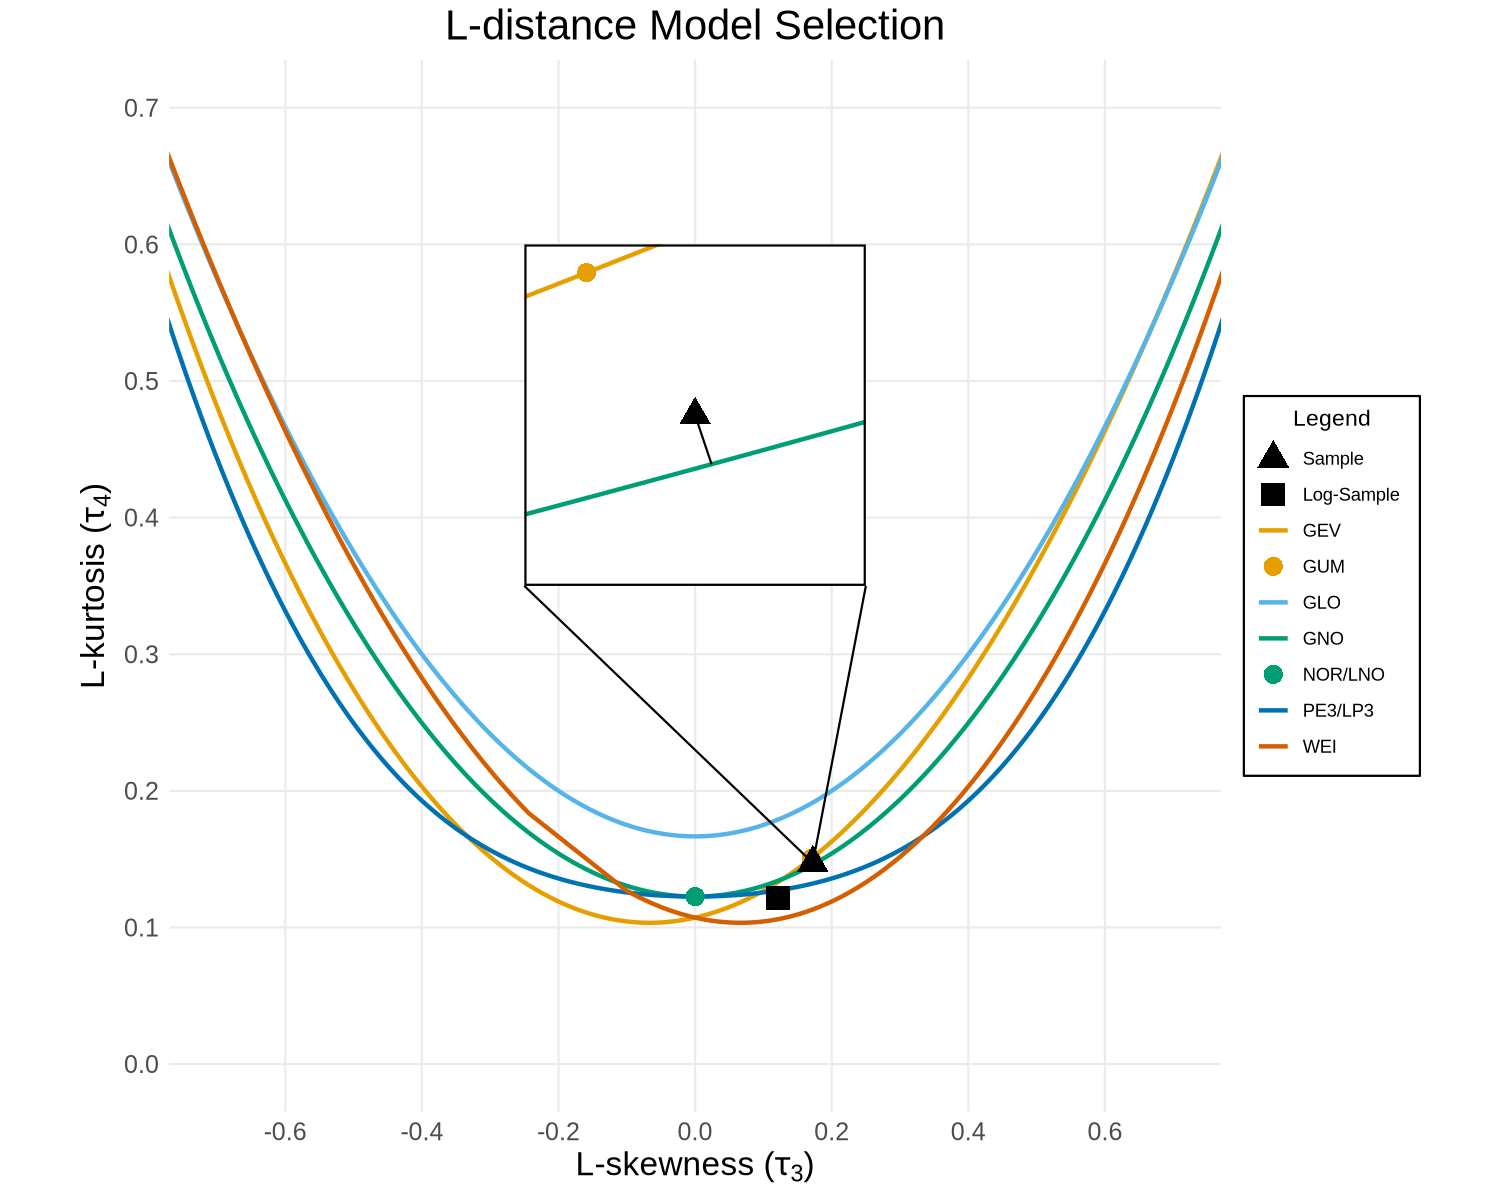

In [3]:
data_decomposed <- ams_decomposition(df$max, df$year, trend)

selection <- select_ldistance(data_decomposed)

print(selection$recommendation)

plot_lmom_diagram(selection)

**Conclusion**: The generalized normal (GNO) distribution is ideal for the data.



## Parameter Estimation

Because L-moments parameter estimation requires stationarity, we use maximum likelihood estimation for non-stationary models.
The `fit_maximum_likelihood` function implements maximum likelihood estimation for both stationary and non-stationary distributions.
It has two required arguments: 

- `data`: The annual maximum streamflow observations. 
- `model`: A three-letter code corresponding to a probability distribution (ex. `"GNO"`).

Since the dataset has a non-stationary trend, two additional arguments are required:

- `years`: The corresponding vector of years for the observations in `data`.
- `trend`: The non-stationary `trend` object described above.

In [4]:
fit <- fit_maximum_likelihood(
	df$max,
	"GNO",
	years = df$year,
	trend = trend
)

print(fit$params)
print(fit$mll)

[1] 224.0496619 -35.5153685  54.6324886  -0.3689085
[1] -590.7329


**Note**: The fitted parameters are: $(\mu_0, \mu_1, \sigma, \kappa)$, where the time-dependent location is modeled as $\mu(t) = \mu_0 + \mu_1 t$.

## Uncertainty Quantification

Uncertainty quantification is also essential for non-stationary probability distributions.
In addition fittedto sample bootstrapping, the framework implements the regula-falsi profile likelihood (RFPL) method for MLE.
The `uncertainty_rfpl` method has two required arguments:

- `data`: The annual maximum streamflow observations. 
- `model`: A three-letter code corresponding to a probability distribution (ex. `"GNO"`).

Since the dataset has a non-stationary trend, three additional arguments are required:

- `years`: The corresponding vector of years for the observations in `data`.
- `trend`: The non-stationary `trend` object described above.
- `slices`: The years at which return levels are computed.

[1] 179.6555 233.5731 269.1684 303.2462 347.4806 380.9029


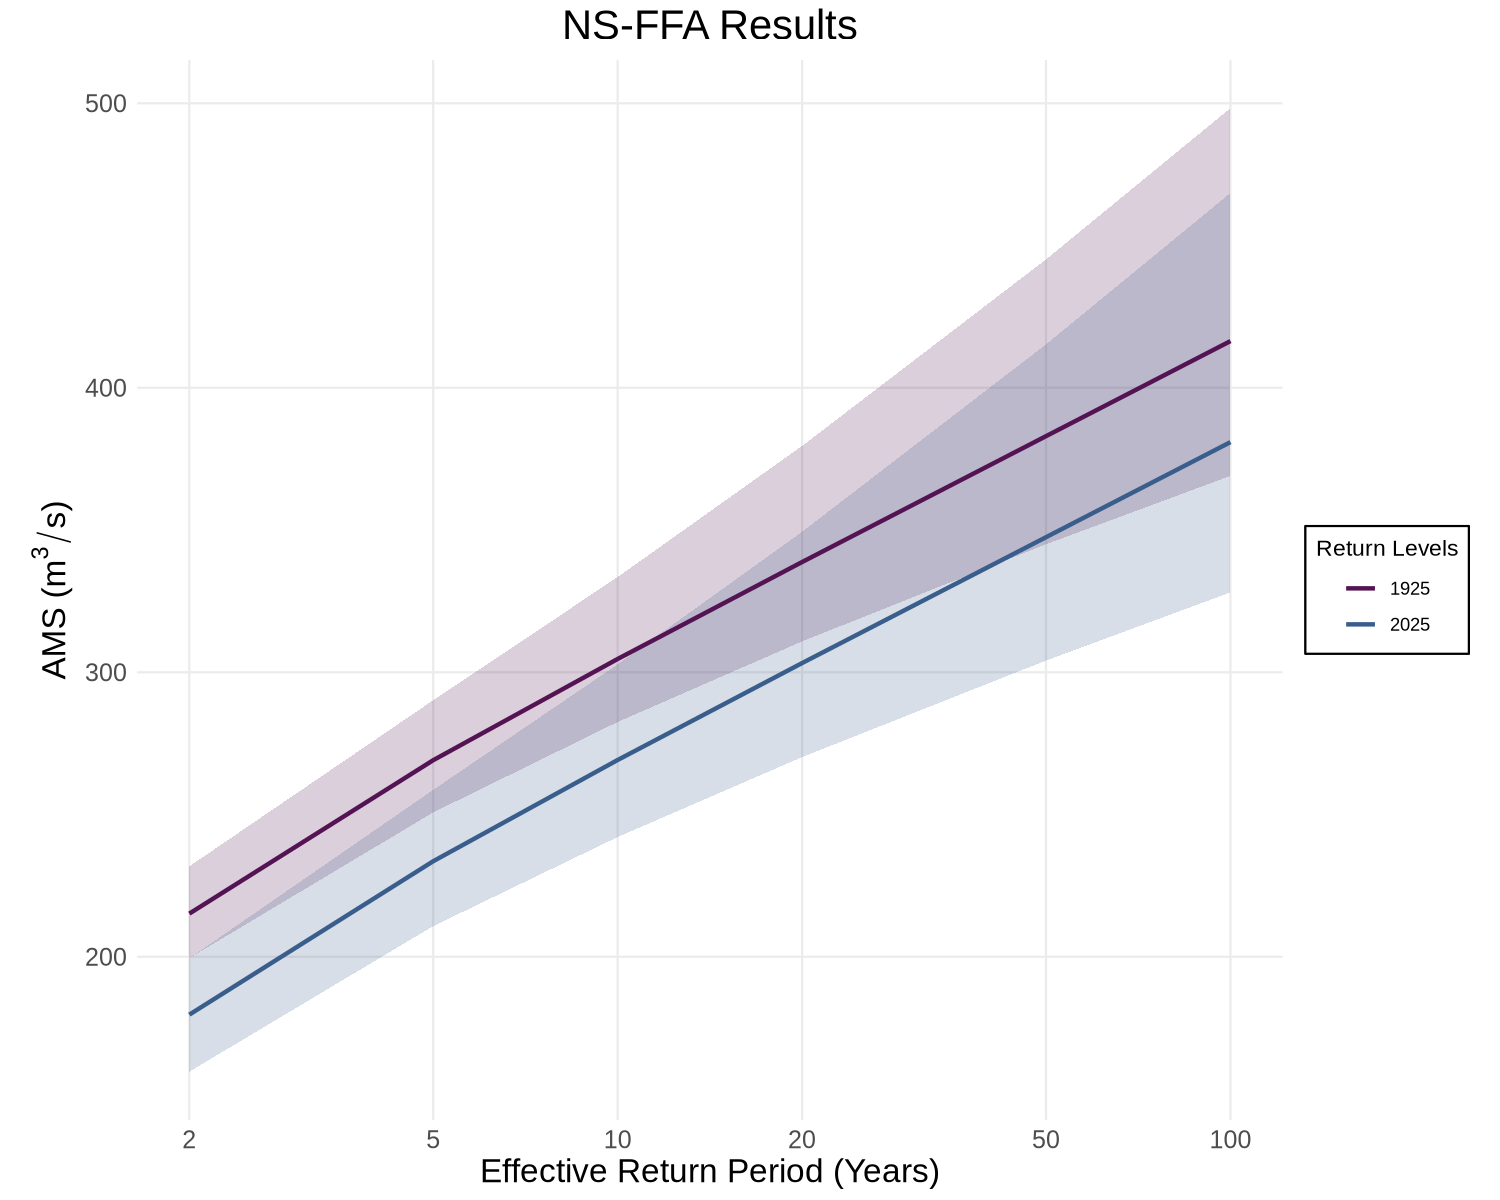

In [5]:
uncertainty <- uncertainty_rfpl(
	df$max,
	"GNO",
	years = df$year,
	trend = trend,
	slices = c(1925, 2025)
)

print(uncertainty[[2]]$estimates)

plot_nsffa(uncertainty)

**Example Conclusion**: In the year 2025, there is a roughly $1/20$ chance of a streamflow event of  $303.2462\text{m}^3/\text{s}$.

**Note**: Under non-stationarity, the return period reflects the probability distribution for a fixed year rather than a long-run average.
To clarify this difference from stationary FFA, the phrase "effective return period" is used.